In [7]:
import os
from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Coron3Pipeline
import jwst.associations
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from glob import glob
import astropy.io.fits as fits
import numpy as np

In [8]:
os.environ["CRDS_PATH"] = '/home/sarperyn/crds_cache/jwst_ops'
os.environ["CRDS_SERVER_URL"] = 'https://jwst-crds.stsci.edu'

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

# figure sizes and resolutions
rcParams['figure.figsize'] = [11,8]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 80

In [10]:
import jwst
print(jwst.__version__)

1.8.2


# Pipeline things



<div class="alert alert-block alert-info">
Now we have the fits files. We will create our coronagrahic images using the JWST pipeline. Our data has the suffix <b>.rateints</b> just like we needed. 
While processing coronagraphy data, the common procedure is using the following pipeline:
    <ul> 
        <li> calwebb_detector1 $\rightarrow$ <strong>from jwst.pipeline import Detector1Pipeline</strong>
        <li> calwebb_image2  $\rightarrow$ <strong>from jwst.pipeline import Image2Pipeline</strong>
        <li> calwebb_coron3  $\rightarrow$ <strong>from jwst.pipeline import Coron3Pipeline</strong>
    </ul>
</div>

We have the outputs of the first stage. They all have the `rateints.fits` suffix. By passing them through the second pipeline we are going to end up with `calints.fits` files which is a last step before getting the coron products.

In [24]:
# Path containing the rateints data
path_stage1 = '/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/mastDownload/'

In [25]:
def show(array,title,unit,min=0,max=1000):
    array = np.squeeze(array)
    plt.figure(figsize=(10,10))
    plt.imshow(array,clim=(min,max),origin='lower')
    plt.title(title)
    plt.colorbar().set_label(unit)

### Stage2

In [26]:
def runimg2(filename, output_dir):
    
    img2 = Image2Pipeline()
    img2.output_dir = output_dir
    img2.save_results = True
    img2.run(filename)

In [27]:
rateints_files = glob(os.path.join(path_stage1, '*rateints.fits'))
path_stage2 = path_stage1.replace('stage1', 'stage2')

In [28]:
if not os.path.exists(path_stage2):
    os.makedirs(path_stage2)

In [29]:
rateints_files

['/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/mastDownload/jw01386001001_02102_00001_nrcalong_rateints.fits',
 '/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/mastDownload/jw01386001001_03102_00001_nrcalong_rateints.fits',
 '/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/mastDownload/jw01075001001_03105_00001_nrca2_rateints.fits',
 '/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/mastDownload/jw01075001001_03105_00001_nrca1_rateints.fits']

In [30]:
for f in rateints_files:
    runimg2(f,path_stage2)

2022-11-07 13:24:11,440 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2022-11-07 13:24:11,448 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-11-07 13:24:11,450 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-11-07 13:24:11,452 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-11-07 13:24:11,453 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2022-11-07 13:24:11,455 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2022-11-07 13:24:11,873 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/mastDownload/jw01386001001_02102_00001_nrcalong_rateints.fits',).
2022-11-07 13:24:11,890 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/home/sarperyn/sarperyurtseven/Pro

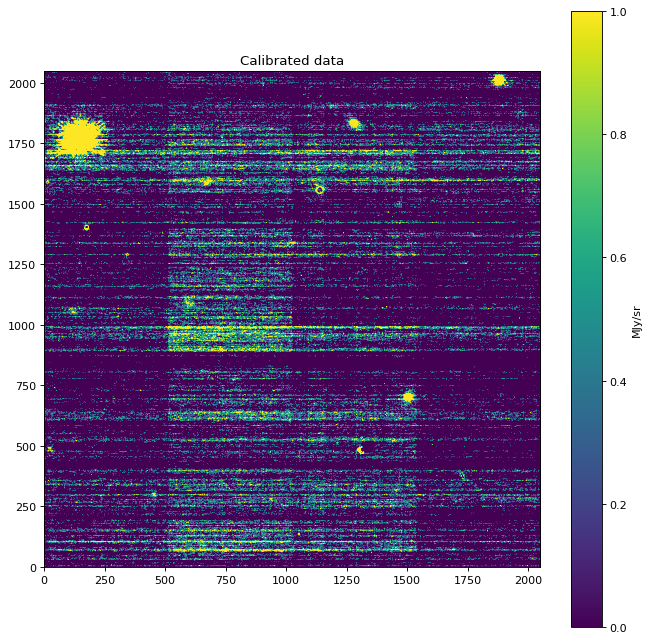

In [46]:
#calints_data = fits.getdata(os.path.join(path_stage2, 'jw01075001001_03105_00001_nrca1_calints.fits'))
show(np.arcsinh(calints_data), 'Calibrated data', 'MJy/sr', max=1)

In [43]:
np.arcsinh(calints_data).max()

10.597964

### Stage 3

The stage 3 is kinda different than the other steps. To run this step we need an association (ASN) file. Thus, we need some functions to create ASN files.

In [53]:
def create_asn(folder,detectors,filter_name):
    asnlist = []
    for detec in detectors:
        asnfile = 'l3asn_{}.json'.format(detec)
        cal_files = glob(os.path.join(folder, '*{}_calints.fits'.format(detec)))
        if cal_files != []:
            print('Step 3: Found ' + str(len(cal_files)) + ' input files to process for detector {}'.format(detec))
            # Name of the final product for the detector
            prodname = 'ima_{}_{}'.format(filter_name,detec)
            asnlist.append(asnfile)
            # Write the ASN file
            writeasn(cal_files,asnfile,prodname)

    # A common ASN file for all dithers and detectors
    asnfile = 'l3asn.json'
    cal_files = glob(os.path.join(folder, '*calints.fits'))
    prodname = 'ima_{}'.format(filter_name)
    writeasn(cal_files,asnfile,prodname)
    asnlist.append(asnfile)

    return(asnlist)

In [54]:
# Useful function to write out a Lvl3 association file from an input list
def writeasn(files,asnfile,prodname):
    # Define the basic association of science files
    asn = jwst.associations.asn_from_list.asn_from_list(files,rule=DMS_Level3_Base,product_name=prodname)
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [32]:
def runimg3(filename, output_dir):
    filename = os.path.join(output_dir,filename)
    img3 = Coron3Pipeline()
    img3.output_dir = output_dir
    img3.save_results = True
    img3.run(filename)

In [33]:
path_stage2

'/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/mastDownload/'

In [35]:
#asnlist = create_asn(path_stage2, ['a1'], 'f210m')
#print(asnlist)

In [36]:
path_stage3 = path_stage1.replace('stage0', 'stage3')
if not os.path.exists(path_stage3):
    os.makedirs(path_stage3)

In [37]:
path_stage3

'/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/mastDownload/'

In [38]:
os.path.join(path_stage3,'jw01075-o001_20221014t190114_image2_040_asn.json')

'/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/mastDownload/jw01075-o001_20221014t190114_image2_040_asn.json'

In [92]:
#Run the stage 3 for detector B1
runimg3('jw01075-o001_20221014t190114_image2_040_asn.json',path_stage3)

2022-11-07 11:08:28,967 - stpipe.Coron3Pipeline - INFO - Coron3Pipeline instance created.
2022-11-07 11:08:28,969 - stpipe.Coron3Pipeline.stack_refs - INFO - StackRefsStep instance created.
2022-11-07 11:08:28,972 - stpipe.Coron3Pipeline.align_refs - INFO - AlignRefsStep instance created.
2022-11-07 11:08:28,974 - stpipe.Coron3Pipeline.klip - INFO - KlipStep instance created.
2022-11-07 11:08:28,975 - stpipe.Coron3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-11-07 11:08:28,977 - stpipe.Coron3Pipeline.resample - INFO - ResampleStep instance created.
2022-11-07 11:08:29,711 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline running with args ('/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/mastDownload/JWST/jw01075001001_03105_00001_nrca1/jw01075-o001_20221014t190114_image2_040_asn.json',).
2022-11-07 11:08:29,721 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

In [34]:
along_data = fits.getdata(os.path.join(path_stage3, ''))
show(b1_data, 'Mosaic on detector a5-b5', 'MJy/sr', max = 300)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sarperyn/sarperyurtseven/ProjectFiles/CoronFiles/mastDownload/fits file'